In [1]:
import random
from collections import deque
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time

print(pd.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create the environment
# Blackjack env source: https://github.com/sjchoi86/advanced-tensorflow/blob/master/rl/env/blackjack.py
tf.keras.backend.clear_session()
env = gym.make('Blackjack-v1')

# Define the neural network
def create_model():
    model = tf.keras.models.Sequential([
        # tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
        tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
        # tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(env.action_space.n)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
    return model


# Define the epsilon greedy strategy
def get_action(model, state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(env.action_space.n)
    return np.argmax(model.predict(state, verbose=0))


# Define the replay memory
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))


class BatchLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_logs = []
        self.total_batches_seen = 0
        self.log_df = None

    def on_train_batch_end(self, batch, logs=None):
        self.total_batches_seen += 1
        self.batch_logs.append({'Iteration': self.total_batches_seen, 'Loss': logs['loss'], 'Accuracy': logs['accuracy']})

    def on_epoch_end(self, epoch, logs=None):
        # Create the log DataFrame at the end of each epoch
        self.log_df = pd.DataFrame(self.batch_logs)
logger = BatchLogger()

# Define training parameters
epochs = 1
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
episodes = 3_000  # 2_000
batch_size = 2 ** 16 #  8192  # 32
gamma = 1  # 0.95
replay_buffer = ReplayBuffer(batch_size * 2)


# Create the DQN model
model = create_model()

# Training loop
start_time = time.time()  # Get the current time
for e in range(episodes):
    if e % 100 == 0:
        print(f"Episode {e} | epsilon {epsilon}")

    state = np.reshape(env.reset(), [1, 3])

    done = False
    while not done:
        action = get_action(model, state, epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, 3])
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

    # Replay
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    states = np.squeeze(np.array(states), axis=1)
    targets = model.predict(np.array(states), verbose=0)

    next_states = np.squeeze(np.array(next_states), axis=1)
    next_q_values = model.predict(np.array(next_states), verbose=0)

    for i, done in enumerate(dones):
        if done:
            targets[i][actions[i]] = rewards[i]
        else:
            targets[i][actions[i]] = rewards[i] + gamma * np.amax(next_q_values[i])
    model.fit(np.array(states), targets, epochs=epochs, verbose=0, callbacks=[logger],)

    # Adjust epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


end_time = time.time()  # Get the current time again after your code has run
execution_time = end_time - start_time  # Calculate the difference
print(f"The execution time was: {execution_time} seconds")


2.0.3
Num GPUs Available:  0
Episode 0 | epsilon 1.0
Episode 100 | epsilon 0.6057704364907278
Episode 200 | epsilon 0.3669578217261671
Episode 300 | epsilon 0.22229219984074702
Episode 400 | epsilon 0.1346580429260134
Episode 500 | epsilon 0.08157186144027828
Episode 600 | epsilon 0.0494138221100385
Episode 700 | epsilon 0.029933432588273214
Episode 800 | epsilon 0.018132788524664028
Episode 900 | epsilon 0.01098430721937979
The execution time was: 158.70507526397705 seconds


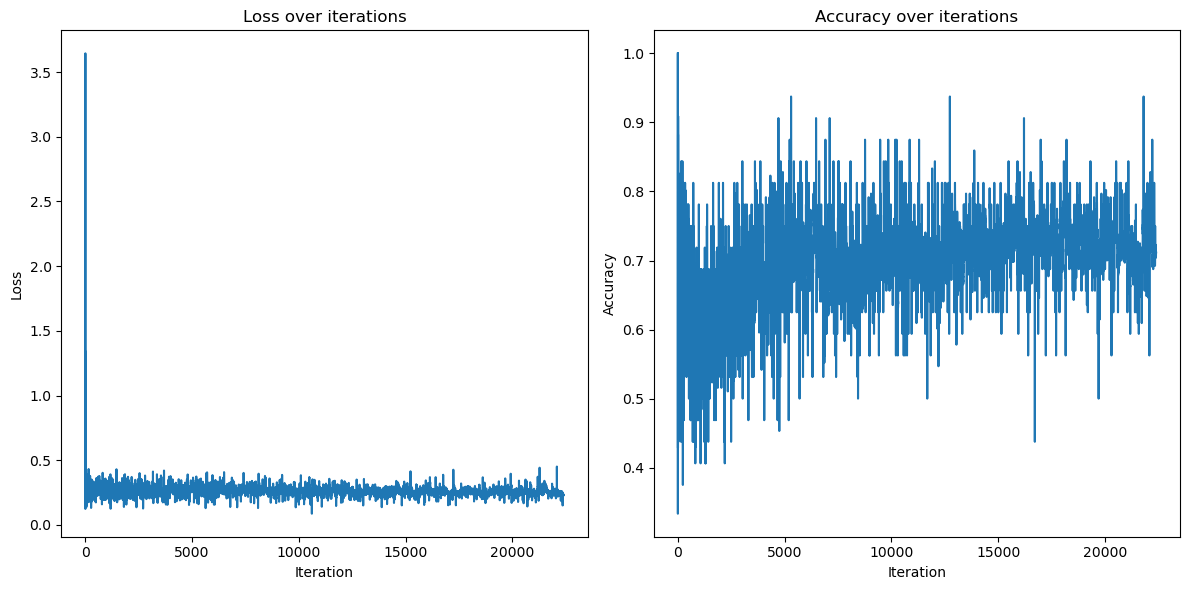

In [2]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(logger.log_df['Iteration'], logger.log_df['Loss'])
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(logger.log_df['Iteration'], logger.log_df['Accuracy'])
plt.title('Accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [3]:

basic_strategy_hard_grid = [
    # Dealer Upcard
    # 2, 3, 4, 5, 6, 7, 8, 9, 10, A
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *4*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *5*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *6*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *7*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *8*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *9*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *10*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *11*#
    [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, ],  # *12*#
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ],  # *13*#
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ],  # *14*#
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ],  # *15*#
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ],  # *16*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *17*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *18*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *19*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *20*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *21*#
]

basic_strategy_soft_grid = [
    # Dealer Upcard
    # 2, 3, 4, 5, 6, 7, 8, 9, 10, A
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *4*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *5*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *6*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *7*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *8*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *9*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *10*#
    # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *11*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *12*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *13*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *14*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *15*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *16*#
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],  # *17*#
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ],  # *18*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *19*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *20*#
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # *21*#
]


def basic_strategy(player_hand, dealer_upcard, usable_ace):
    """
    Returns the ideal play for the player given a blackjack game state.

    Args:
        player_hand (int): The value of the player's hand.
        dealer_upcard (int): The value of the dealer's up-card.
        usable_ace (bool): True if the player has a soft ace, False otherwise.

    Returns:
        int: The recommended play for the player. 0 for 'stand', 1 for 'hit'.
    """

    if (not usable_ace and player_hand < 4) or (usable_ace and player_hand < 12) or player_hand > 21:
        raise ValueError(f"Invalid player hand value {player_hand}. Must be between 4 and 21.")

    if dealer_upcard < 1 or dealer_upcard > 10:
        raise ValueError(f"Invalid dealer up-card value {dealer_upcard}. Must be between 2 and 11.")

    i_player_hand = player_hand - 12 if usable_ace else player_hand - 4
    i_dealer_upcard = 9 if dealer_upcard == 1 else dealer_upcard - 2

    # print(f"{usable_ace} | {player_hand}-{i_player_hand} | {dealer_upcard}-{i_dealer_upcard}")
    if usable_ace:
        return basic_strategy_soft_grid[i_player_hand][i_dealer_upcard]
    else:
        return basic_strategy_hard_grid[i_player_hand][i_dealer_upcard]


Total mismatches: 50
Total cases: 280
Mismatch percentage: 17.857142857142858


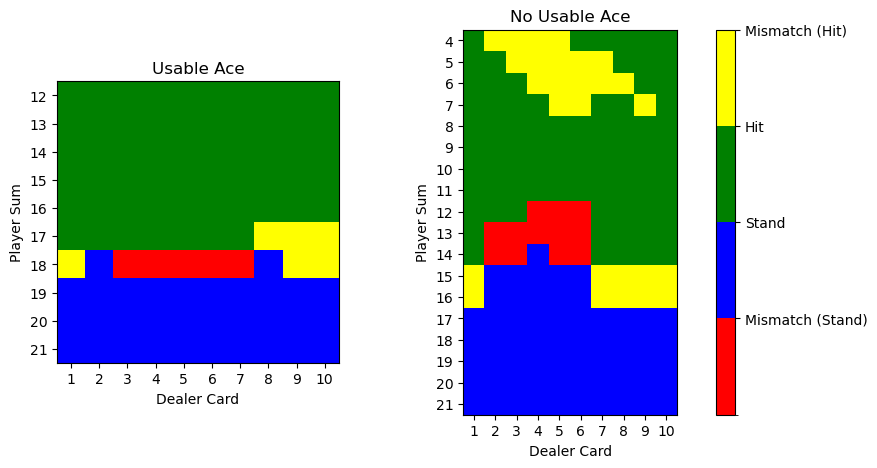

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Create two grids to hold the results
# Player sum can range from 12 to 21 inclusive when ace is usable, hence the size is 10
# Player sum can range from 4 to 21 inclusive when no ace is usable, hence the size is 18
grid_usable_ace = np.zeros((10, 10))
grid_no_usable_ace = np.zeros((18, 10))

num_mismatches = 0
total_cases = 0

# Loop over player sums, dealer cards, and usable ace
for dealer_card in range(1, 11):  # Dealer card can be from 1 to 10
    for usable_ace in [False, True]:  # Usable ace can be True or False
        # Player sum starts from 12 when ace is usable, 4 otherwise
        for player_sum in range(12 if usable_ace else 4, 22):  # Player sum can be from 4/12 to 21

            # Create the state
            state = np.array([[player_sum, dealer_card, int(usable_ace)]])

            # Get the actions chosen by the DQN model and the basic strategy
            dqn_action = np.argmax(model.predict(state, verbose=0))
            basic_strategy_action = basic_strategy(player_sum, dealer_card, usable_ace)

            # Compare the actions
            if dqn_action != basic_strategy_action:
                num_mismatches += 1
                # Mark the cell in the appropriate grid
                if usable_ace:
                    grid_usable_ace[player_sum - 12, dealer_card - 1] = 2 if basic_strategy_action == 1 else -2
                else:
                    grid_no_usable_ace[player_sum - 4, dealer_card - 1] = 2 if basic_strategy_action == 1 else -2
            else:
                if usable_ace:
                    grid_usable_ace[player_sum - 12, dealer_card - 1] = 0 if basic_strategy_action == 1 else -1
                else:
                    grid_no_usable_ace[player_sum - 4, dealer_card - 1] = 0 if basic_strategy_action == 1 else -1

            total_cases += 1

print("Total mismatches:", num_mismatches)
print("Total cases:", total_cases)
print("Mismatch percentage:", num_mismatches / total_cases * 100)

# Create a color map to distinguish between 'stand' (-1), 'hit' (1), 
# mismatch where the basic strategy says to 'stand' (-2), 
# and mismatch where the basic strategy says to 'hit' (2)
cmap = colors.ListedColormap(['red', 'blue', 'green', 'yellow'])
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the grids
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im = ax[0].imshow(grid_usable_ace, cmap=cmap, norm=norm, interpolation='nearest')
ax[0].set_title('Usable Ace')
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(range(1, 11))
ax[0].set_yticks(range(10))
ax[0].set_yticklabels(range(12, 22))
ax[0].set_xlabel('Dealer Card')
ax[0].set_ylabel('Player Sum')

im = ax[1].imshow(grid_no_usable_ace, cmap=cmap, norm=norm, interpolation='nearest')
ax[1].set_title('No Usable Ace')
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(1, 11))
ax[1].set_yticks(range(18))
ax[1].set_yticklabels(range(4, 22))
ax[1].set_xlabel('Dealer Card')
ax[1].set_ylabel('Player Sum')

# Add a color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
cbar.set_ticks([-1.5, -0.5, 0.5, 1.5])
cbar.set_ticklabels(['Mismatch (Stand)', 'Stand', 'Hit', 'Mismatch (Hit)'])

plt.show()


In [5]:
np.argmax(model.predict([[12, 5, int(False)]], verbose=0))

1

In [6]:
basic_strategy(12, 5, False)

0